In [1]:
!pip install datasets
# !pip install ipywidgets
# !pip install tqdm
# !pip install tensorflow

In [2]:
from datasets import load_dataset

dataset = load_dataset("sebastiandizon/genius-song-lyrics")
#dataset = load_dataset("sebastiandizon/genius-song-lyrics", split="train[:100000]")

song_lyrics%202.csv:   0%|          | 0.00/9.07G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/19 [00:00<?, ?it/s]

AttributeError: 'DatasetDict' object has no attribute 'select'

In [7]:
dataset = dataset.shuffle(seed=42).select(range(100000))

In [8]:
dataset

Dataset({
    features: ['title', 'tag', 'artist', 'year', 'views', 'features', 'lyrics', 'id', 'language_cld3', 'language_ft', 'language'],
    num_rows: 100000
})

In [9]:
# drop id
dataset = dataset.remove_columns(['id'])

In [10]:
#drop views
dataset = dataset.remove_columns(['views'])

In [11]:
import multiprocessing
multiprocessing.cpu_count()

4

In [12]:
# drop non-english songs
dataset = dataset.filter(
    lambda song: song['language'] == 'en' and song['language_ft'] == 'en' and song['language_cld3'] == 'en',
    num_proc = 4
)

Filter (num_proc=4):   0%|          | 0/100000 [00:00<?, ? examples/s]

In [13]:
# see how many observations/rows in dataset along with our features
dataset

Dataset({
    features: ['title', 'tag', 'artist', 'year', 'features', 'lyrics', 'language_cld3', 'language_ft', 'language'],
    num_rows: 65896
})

In [14]:
import re

In [15]:
# convert each song to a list of string tokens - treat punctuation as token
def generate_tokens(batch):
    #return {"lyric_tokens": [lyrics.split() for lyrics in batch["lyrics"]]}
    return {"lyric_tokens": [re.findall(r"[\w']+|[.,!?;(){}\[\]]", lyrics) for lyrics in batch["lyrics"]]}

dataset = dataset.map(generate_tokens, batched=True, num_proc=4)

Map (num_proc=4):   0%|          | 0/65896 [00:00<?, ? examples/s]

In [16]:
dataset

Dataset({
    features: ['title', 'tag', 'artist', 'year', 'features', 'lyrics', 'language_cld3', 'language_ft', 'language', 'lyric_tokens'],
    num_rows: 65896
})

In [17]:
from collections import deque, defaultdict, Counter
import numpy as np

In [67]:
# start with n-gram model as a baseline
class NGramModel:
  START_TOKEN = "<START>"
  STOP_TOKEN = "<STOP>" # don't worry about stop tokens for now
  UNK_TOKEN = "<UNK>"

  def __init__(self, n, tag, vocab_size, artist="N/A", feature="N/A"):
    self.n = n
    self.count = defaultdict(lambda: defaultdict(lambda: 0))
    self.vocab = set()
    self.vocab_size = vocab_size
    self.tag = tag
    self.lyrics = [] # list of tokenized lyrics in genre
    self.artist = artist
    self.feature = feature

  def fit(self, dataset):
    # get counts of each word in tag
    word_counts = Counter()
    for song in dataset:
      if song['tag'] != self.tag:
        continue
      lowercase_lyrics = [lyrics.lower() for lyrics in song['lyric_tokens']]
      # self.lyrics.append(song['lyric_tokens'])
      # word_counts.update(song['lyric_tokens'])
      self.lyrics.append(lowercase_lyrics)
      word_counts.update(lowercase_lyrics)

    # get vocab - all words with count <  are converted to UNK_TOKEN
    for word, count in word_counts.most_common(self.vocab_size):
      self.vocab.add(word)

    # add START_TOKEN and STOP_TOKEN to vocab
    self.vocab.add(self.START_TOKEN)
    self.vocab.add(self.STOP_TOKEN)

    # calculate our ngram counts: count(word_i | word_{i-1}, word_{i-2},..., word_{i-n+1})
    ngram = deque([self.START_TOKEN] * (self.n - 1))
    for song in self.lyrics:
      for word in song:
        self.count[str(list(ngram))][word] += 1 # update count(word | previous n-1 words)
        ngram.append(self.UNK_TOKEN if word not in self.vocab else word)
        ngram.popleft()

  def get_ngram_probability(self, ngram):
    ngram = [self.UNK_TOKEN if token not in self.vocab else token for token in ngram]
    prior = str(ngram[:-1]) # prior should be ngram except last token
    prior_count = sum(self.count[prior][word] for word in self.count[prior].keys()) # count is in the form count[prior][nth word] -> get prior_counts by summing all count[prior][arbitrary word]
    # probability of ngram should be count(nth word | prior words) / count(prior words)
    return (self.count[prior][ngram[-1]] + 1) / (prior_count + len(self.vocab)) # apply laplace smoothing

  def get_log_likelihood(self, sentence):
    # calculate log likelihood similar to that in hw2
    ll = 0.0
    ngram = deque([self.START_TOKEN] * (self.n - 1))
    for word in sentence:
      ngram.append(word)
      ngram_prob = self.get_ngram_probability(ngram)
      ll += -np.inf if ngram_prob == 0 else np.log(ngram_prob)
      ngram.popleft()
    return ll

  def generate_lyrics(self, ngram):
    # get next most likely word
    prior = str([self.UNK_TOKEN if token not in self.vocab else token for token in ngram])
    most_likely_word = ''
    most_likely_count = 0
    #print(self.count[prior].items())
    for word, count in self.count[prior].items():
      if most_likely_count < count:
        most_likely_count = count
        most_likely_word = word
    return most_likely_word


In [68]:
# check our tags/genres
set(dataset['tag'])

{'country', 'misc', 'pop', 'rap', 'rb', 'rock'}

In [69]:
# let's try trigram with our tag as pop and vocab size of 10000
trigram = NGramModel(n=3, tag="pop", vocab_size=10000)
trigram.fit(dataset)

In [70]:
def gen(ngram, words, next_words):
    prior = deque(words)
    # generate next next_words words
    for i in range(next_words):
        next_word = ngram.generate_lyrics(prior)
        print(next_word)
        prior.append(next_word)
        prior.popleft()

In [71]:
# let's give it some lyrics to start off with and see what it generates
start = ['hi', ',']

# generate next 16 words
gen(trigram, start, 16)

i'm
a
little
bit
of
love
,
love
,
love
,
love
,
love
,
love


In [72]:
# let's play around with different values of n
unigram = NGramModel(n=1, tag="pop", vocab_size=10000)
unigram.fit(dataset)
gen(unigram, [], 16)

,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,


In [73]:
bigram = NGramModel(n=2, tag="pop", vocab_size=10000)
bigram.fit(dataset)
gen(bigram, ['hi'], 16)

,
i
know
that
i
know
that
i
know
that
i
know
that
i
know
that


In [74]:
fourgram = NGramModel(n=4, tag="pop", vocab_size=10000)
fourgram.fit(dataset)
gen(fourgram, ['hi', ',', 'you'], 16)

say
you
love
me
,
love
me
,
love
me
,
love
me
,
love
me


In [75]:
fivegram = NGramModel(n=5, tag="pop", vocab_size=10000)
fivegram.fit(dataset)
gen(fivegram, ['hi', ',', 'you', 'are'], 16)


of
the
lord
2x
my
god
has
made
his
favour
,
to
be
manifested
upon


In [76]:
sixgram = NGramModel(n=6, tag="pop", vocab_size=10000)
sixgram.fit(dataset)
gen(sixgram, ['hi', ',', 'you', 'are', 'my'], 16)


,
beautiful
mess
baby
you
are
my
bеautiful
,
beautiful
mess
baby
you
are
my


In [81]:
# to evaluate our models, we will use lyrics from Gotye's "Somebody That I Used to Know"
test_lyrics = ['now', 'and', 'then', ',', 'i', 'think', 'of', 'all', 'the', 'times', 'you', 'screwed', 'me', 'over']

# get our log likelihoods for our n-grams
ll = []
ll.append(unigram.get_log_likelihood(test_lyrics))
ll.append(bigram.get_log_likelihood(test_lyrics))
ll.append(trigram.get_log_likelihood(test_lyrics))
ll.append(fourgram.get_log_likelihood(test_lyrics))
ll.append(fivegram.get_log_likelihood(test_lyrics))
ll.append(sixgram.get_log_likelihood(test_lyrics))

In [82]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'n-gram vs. Log_Likelihood')

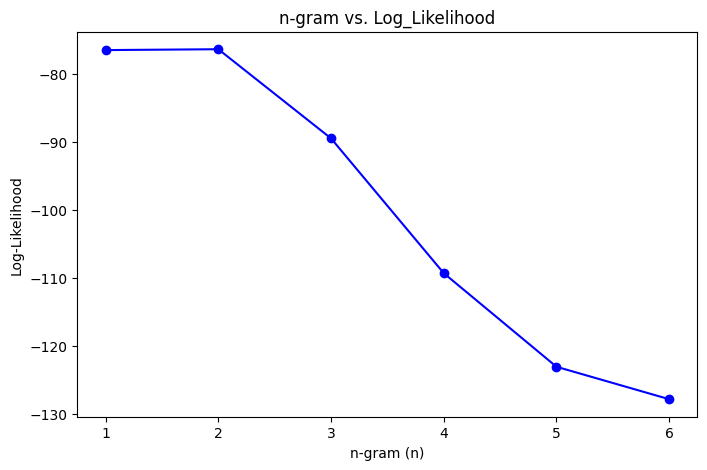

In [83]:
n_values = [1, 2, 3, 4, 5, 6]
plt.figure(figsize=(8, 5))
plt.plot(n_values, ll, marker='o', linestyle='-', color='b')
plt.xlabel("n-gram (n)")
plt.ylabel("Log-Likelihood")
plt.title("n-gram vs. Log_Likelihood")

In [84]:
# to evaluate our models, we will use lyrics from Whitney Houston's "I Wanna Dance With Somebody"
test_lyrics = ['i', 'wanna', 'dance', 'with', 'somebody']

# get our log likelihoods for our n-grams
ll2 = []
ll2.append(unigram.get_log_likelihood(test_lyrics))
ll2.append(bigram.get_log_likelihood(test_lyrics))
ll2.append(trigram.get_log_likelihood(test_lyrics))
ll2.append(fourgram.get_log_likelihood(test_lyrics))
ll2.append(fivegram.get_log_likelihood(test_lyrics))
ll2.append(sixgram.get_log_likelihood(test_lyrics))

Text(0.5, 1.0, 'n-gram vs. Log_Likelihood')

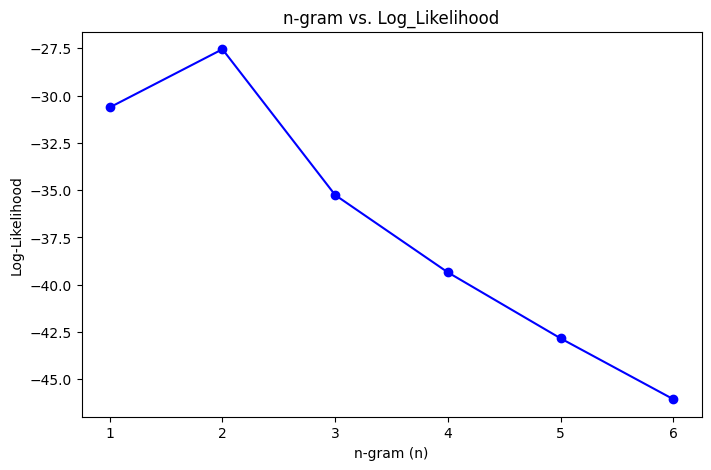

In [85]:
plt.figure(figsize=(8, 5))
plt.plot(n_values, ll2, marker='o', linestyle='-', color='b')
plt.xlabel("n-gram (n)")
plt.ylabel("Log-Likelihood")
plt.title("n-gram vs. Log_Likelihood")